In [1]:
from qiskit import pulse, IBMQ
from qiskit.pulse import DriveChannel 
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit

In [47]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-research', 'guanajuato-1', 'main')
backend = provider.get_backend("ibmq_bogota")

ibmqfactory.load_account:WARNING:2021-04-11 07:46:03,600: Credentials are already in use. The existing account in the session will be replaced.


In [48]:
x_def = backend.defaults().instruction_schedule_map.get('x',qubits = [0])#Default X gate pulse from IBM
x_def

Schedule((0, Play(Drag(duration=160, amp=(0.18959053928306333+0j), sigma=40, beta=-1.189297047561138, name='drag_85d7'), DriveChannel(0), name='drag_85d7')), name="x")

### Gaussian Pulse
The Gaussian pulse usually used for gate pulses is the following function 
$$
\theta_G(t) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\left(\frac{t - \tau/2}{\sigma}\right)^2}
$$

The Pulse is truncated in 4$\sigma$ to reduce the noise and normalized to depend on the amplitude calibrated by us.

$$Pulse = \frac{\left(\theta_G(t) - \theta_G(0)\right)}{1 - \theta_G(0)}$$

Text(0.5, 0, 'time [ns]')

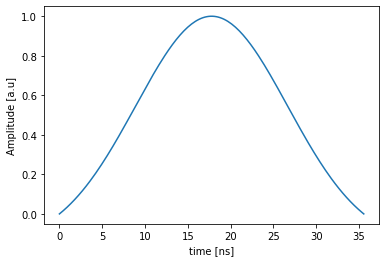

In [49]:
n = 160 # number of samples
dt = backend.configuration().dt # default sample time
tau = n*dt # Pulse duration
sigma = tau/4 #
time = np.linspace(0,tau,n)
theta = lambda t: np.exp(-0.5*((t - tau/2)/sigma)**2)
Samples = (theta(time) - theta(0))/max(theta(time) - theta(0))

fig, ax = plt.subplots()
ax.plot(time*1e9, Samples)
ax.set_ylabel("Amplitude [a.u]")
ax.set_xlabel("time [ns]")

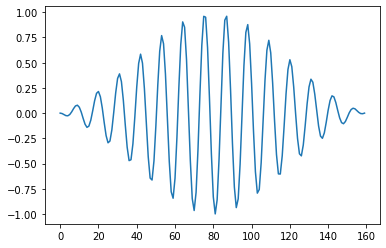

In [50]:
f_def = backend.defaults().qubit_freq_est[0]
def sideband(frequency):
    return np.sin(2*np.pi*(frequency)*time)*Samples
plt.plot(sideband(-400e6))

In [61]:
measure = backend.defaults().instruction_schedule_map.get('measure',qubits = [0])
num_exp = 75 # number of experiments
amp = 0.3
frequencies = np.linspace(-400e6, -300e6, num_exp)
scheds = []
for f in frequencies:
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.play(pulse.Waveform(amp * sideband(f)), DriveChannel(0))
            pulse.call(measure)
    scheds.append(Schedule)

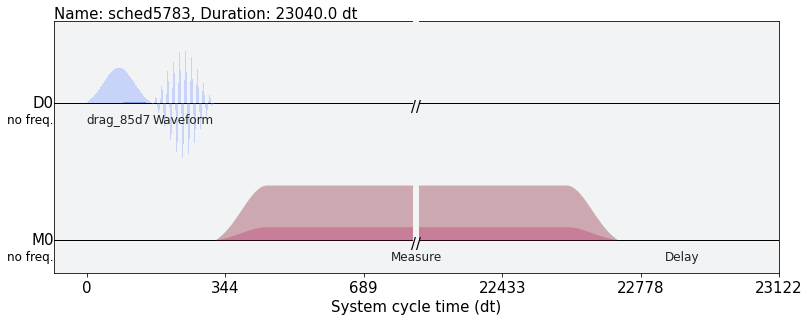

In [62]:
scheds[-1].draw()

In [63]:
shots = 1000
job = backend.run(scheds, meas_level=1, meas_return="single", shots=shots)
job_monitor(job)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [64]:
result = job.result()

In [65]:
output = []
for i in range(num_exp):
    output.append(result.get_memory(i))
output = np.array(output)
output = np.squeeze(output)

### Frequency calibration

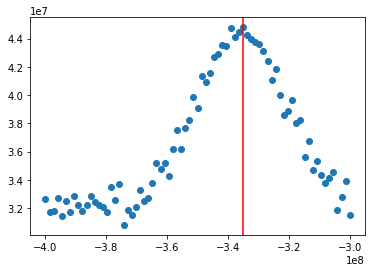

In [73]:
mean = np.mean(output, axis=1)
num = 75
f12 = frequencies[np.argmax(mean[:,0])]
plt.scatter(frequencies,mean[:,0])
plt.axvline(f12, color="red")
plt.title(f"Frequency calibrated {f12}")

### Amplitude Calibration

In [94]:
scheds = []
amplitudes = np.linspace(0,0.5,50)
for amp in amplitudes:
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.play(pulse.Waveform(amp * sideband(f12)), DriveChannel(0))
            pulse.call(measure)
    scheds.append(Schedule)

In [92]:
shots = 1000
job_amp = backend.run(scheds, meas_level=1, meas_return="single", shots=shots)
job_monitor(job_amp)
job = backend.retrieve_job("6072f330b571737f8397e812")
results = job.result()

In [101]:
amp_cal = []
for i in range(50):
    amp_cal.append(results.get_memory(i))
amp_cal = np.array(amp_cal)
amp_cal = np.squeeze(amp_cal)

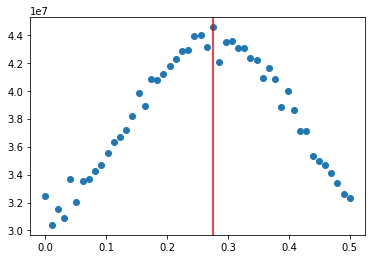

In [104]:
mean_amp = np.mean(amp_cal, axis=1)
amp12 = amplitudes[np.argmax(mean_amp[:,0])]
plt.scatter(amplitudes,mean_amp[:,0])
plt.axvline(amp12, color="red")

### Loading Dataset
The Irish data set is used here for clasification using the armonk device 

In [119]:
with open("iris.data","r") as file:
    f = file.read()
f = f.split("\n")[:-2]
data = []
classification = ["Iris-setosa","Iris-versicolor","Iris-virginica"]
for i in f:
    case = []
    for j in i.split(","):
        if j == "Iris-setosa":
            case.append(0)
        elif j == "Iris-versicolor":
            case.append(1)
        elif j == "Iris-virginica":
            case.append(2)
        else:
            case.append(float(j))
    data.append(case)
data = np.array(data)
minD = np.min(data, axis=0)
maxD = np.max(data, axis=0)
dataN = (data - minD) / (maxD - minD)


In [154]:
x01 = x_def # Gate X to rotate in the |0> |1> basis
x12 = pulse.Schedule()
x12 += pulse.Play(pulse.Waveform(amp12 * sideband(f12)), DriveChannel(0))
x02 = pulse.Schedule()
x02 += x01
x02 += x12
amp01 = x_def.instructions[0][1].pulse.amp.real

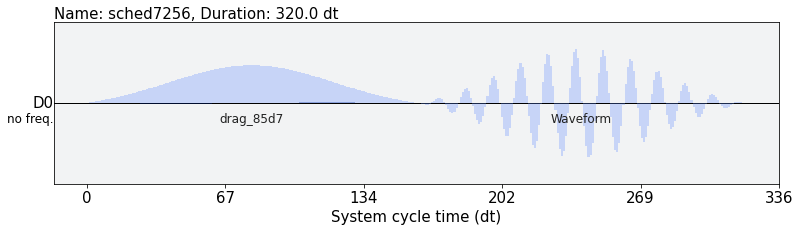

In [155]:
x02.draw()

In [158]:
def QNN_Circuit(x, params=None):
    with pulse.build() as sched:
        with pulse.align_sequential():
            pulse.call(x01)
            pulse.play(pulse.Waveform(x[0]*amp12 * sideband(f12)), DriveChannel(0))
            pulse.call(x12)
            pulse.play(pulse.Waveform(x[1]*amp01 * Samples), DriveChannel(0))
            pulse.call(x02)
            pulse.play(pulse.Waveform(x[2]*amp12 * sideband(f12)), DriveChannel(0))
            pulse.call(x01)
            pulse.play(pulse.Waveform(x[3]*amp01 * Samples), DriveChannel(0))
    return sched

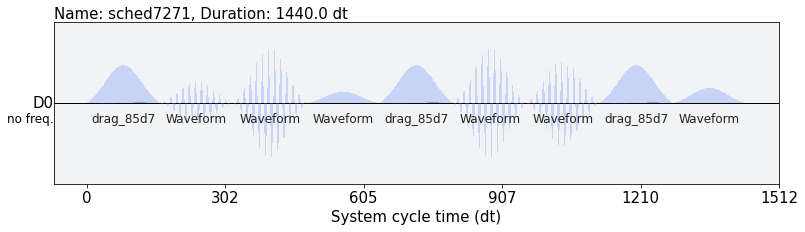

In [160]:
QNN_Circuit([0.4,0.3,0.8, 0.4]).draw()

### The next step is add more parameters to fit and train the QNN_Circuit